# 1.2 RDD Data Processing

This notebook demonstrates some of the more advanced uses of Spark RDD API for data processing.

We will analyze the `Air Temperature` data set from BOM,  which contains historial maximum daily temperatures from multiple weather stations in New South Wales going back to the 19th century.

Let's have look at the data first (`data/nsw_temp.csv` file):

In [1]:
%%sh 
gsutil cp gs://graphenoxidexyz/demo/data/nsw_temp.csv .
head -n 5 nsw_temp.csv

Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
IDCJAC0010,061087,1965,01,01,25.6,,Y
IDCJAC0010,061087,1965,01,02,32.2,1,Y
IDCJAC0010,061087,1965,01,03,23.1,1,Y
IDCJAC0010,061087,1965,01,04,25.6,1,Y


Copying gs://graphenoxidexyz/demo/data/nsw_temp.csv...
/ [1 files][ 12.9 MiB/ 12.9 MiB]                                                
Operation completed over 1 objects/12.9 MiB.                                     


The data appears to be the `csv` format with the header with the column names in the first line.

Let's load the data as an RDD:

In [2]:
# use `textFile` to create an RDD of lines in the text files

dataRDD = sc.textFile('gs://graphenoxidexyz/demo/data/nsw_temp.csv')

# let's see how many lines are there in the RDD

print("Lines in the RDD: %s " % dataRDD.count())

# let's preview the RDD
dataRDD.take(5)

Lines in the RDD: 352737 


[u'Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality',
 u'IDCJAC0010,061087,1965,01,01,25.6,,Y',
 u'IDCJAC0010,061087,1965,01,02,32.2,1,Y',
 u'IDCJAC0010,061087,1965,01,03,23.1,1,Y',
 u'IDCJAC0010,061087,1965,01,04,25.6,1,Y']

### Important RDD internals

In order to be able to process RDDs in the distributed manner Spark splits the RDD's data into multiple chunks called paritition.

For a text file the partition may represent a range of lines in the file.  

The number of partitions in the RDD will determine the maximum level of parallelism possible for processing of this RDD, that is the RDD with say two partitions can only be processed by two executors in parallel **even if many more are available**. 

Spark usually make a good guess about how many partition to use but in come cases, when the input data set is small and processing is compute intensive the number may need to be adjusted (to match the number of executors).

In [4]:
# check the number of paritions in the RDD
print(dataRDD.getNumPartitions())

# force Spark to split the file to at least 4 partitions
dataRDD = sc.textFile('gs://graphenoxidexyz/demo/data/nsw_temp.csv', 16)
print(dataRDD.getNumPartitions())

4
16


RDDs may contain any *serializable* (with `pickle`) objects. 

For our data set let's represent each measurement as a `namedtuple` `BomRecord`.

Let's convert our data set to the `RDD` of `BomRecord`s:

In [5]:
from collections import namedtuple

# define the namedtuple BomRecord
BomRecord = namedtuple('BomRecord', 
        ['product_code', 'station_number', 'year', 'month', 'day', 'max_temp', 'days_of_acc', 'quality'])

# filter out the header line and convert each line to the BomRecord
bomRDD = dataRDD \
    .filter(lambda line: line.startswith('IDCJAC')) \
    .map(lambda line: BomRecord(*line.split(',')))

bomRDD.take(3)

[BomRecord(product_code=u'IDCJAC0010', station_number=u'061087', year=u'1965', month=u'01', day=u'01', max_temp=u'25.6', days_of_acc=u'', quality=u'Y'),
 BomRecord(product_code=u'IDCJAC0010', station_number=u'061087', year=u'1965', month=u'01', day=u'02', max_temp=u'32.2', days_of_acc=u'1', quality=u'Y'),
 BomRecord(product_code=u'IDCJAC0010', station_number=u'061087', year=u'1965', month=u'01', day=u'03', max_temp=u'23.1', days_of_acc=u'1', quality=u'Y')]

It looks good, but we can improve it by converting each column to its actual `python` type:

In [6]:
# returns a function that convert a list of string values to 
# the values of types defined in `types`
def apply_types(*types):
    return lambda strlist: ( t(v) if v else None for t,v in zip(types, strlist))

bomRDD = dataRDD \
    .filter(lambda line: line.startswith('IDCJAC')) \
    .map(lambda line: BomRecord(*apply_types(str, str, int, int, int, float, str, bool)(line.split(','))))

bomRDD.take(3)

[BomRecord(product_code='IDCJAC0010', station_number='061087', year=1965, month=1, day=1, max_temp=25.6, days_of_acc=None, quality=True),
 BomRecord(product_code='IDCJAC0010', station_number='061087', year=1965, month=1, day=2, max_temp=32.2, days_of_acc='1', quality=True),
 BomRecord(product_code='IDCJAC0010', station_number='061087', year=1965, month=1, day=3, max_temp=23.1, days_of_acc='1', quality=True)]

Another important consideration in working with RDDs is *caching*, that is keeping the entire (or part) of the RDD in memory, to improve the performance.

There are two reasons for this:

* accessing data in memory is much faster than acessing data on a (spinning) disk ( ~ 10^5 times faster)
* caching can be used to capture the results of compute intensive transformations 

Let's see how that works in practice:

In [7]:
# print the current storage level
print(bomRDD.getStorageLevel())

# mark the RDD for caching
bomRDD.cache()

# print the cached storage level
print(bomRDD.getStorageLevel())

Serialized 1x Replicated
Memory Serialized 1x Replicated


In [11]:
# Perform an action in the RDD

bomRDD.count()

# Peform the action again and notice if it runs faster

352696


Once the RDD is cached in memory (Memory Serialized 1x Replicated) the second `count` operation works much faster.

### Analysing Data

Now that we have created a convenient representation of the data and cached them for performance we are ready to ask a few analytical questions. 

For example: how many stations and years of observations are there in the dataset as well as what are some of the statistics of the maximum temperature measurements?

In [12]:
import operator

print("#stations: %s " % bomRDD.map(lambda r:r.station_number).distinct().count())
print("#years: %s" % bomRDD.map(operator.attrgetter('year')).distinct().count())

print("Max temp stats:")
print(bomRDD.map(operator.attrgetter('max_temp')).filter(lambda v: v is not None).stats())

#stations: 41 
#years: 155
Max temp stats:
(count: 314092, mean: 22.8129516193, stdev: 5.31792943713, max: 46.5, min: 0.0)


We can check how many observations there are for each year:

In [13]:
observationsPerYear = bomRDD.map(lambda r: (r.year, 1)) \
    .reduceByKey(operator.add) \
    .sortByKey() \
    .collect()
    
observationsPerYear[0:3]

[(1859, 365), (1860, 366), (1861, 365)]

And we can use `matplotlib` together with `pandas` to visualise the result:

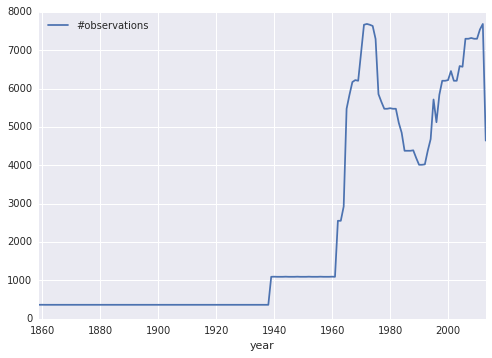

In [14]:
import pandas as pd
from matplotlib import pyplot as plt

observationsPerYearPD = pd.DataFrame.from_records(observationsPerYear, columns=['year', '#observations'], index='year')
plt.close()
observationsPerYearPD.plot(kind='line')
plt.show()
display()

Finally we can find the station with most observations and calculate and plot average yearly temperatures for this station over the entire period of data collection: 

In [15]:
# find the station with the most observations

top_station_id, top_number = bomRDD \
    .filter(lambda r: r.max_temp is not None) \
    .map(lambda r: (r.station_number, 1)) \
    .reduceByKey(operator.add) \
    .sortBy(lambda t:t[1], False) \
    .first()
    
print("Station: %s has most observations: %s" % (top_station_id, top_number))

Station: 066062 has most observations: 56317


In [16]:
# compute the yearly averages for the station with most observations

seqOp = (lambda sumAndCount, v: (sumAndCount[0] + v, sumAndCount[1] + 1))
combOp = (lambda sumAndCount1, sumAndCount2: (sumAndCount1[0] + sumAndCount2[0], sumAndCount1[1] + sumAndCount2[1]))

averageYearlyTemps = bomRDD \
    .filter(lambda r: r.station_number == top_station_id) \
    .filter(lambda r: r.max_temp is not None) \
    .map(lambda r: (r.year, r.max_temp)) \
    .aggregateByKey((0.0, 0), seqOp, combOp) \
    .map(lambda (year,sumAndCount): (year, sumAndCount[0]/ sumAndCount[1])) \
    .sortByKey() \
    .collect()
    
print(averageYearlyTemps[0:3])

[(1859, 21.399452054794523), (1860, 20.276986301369863), (1861, 20.864657534246582)]


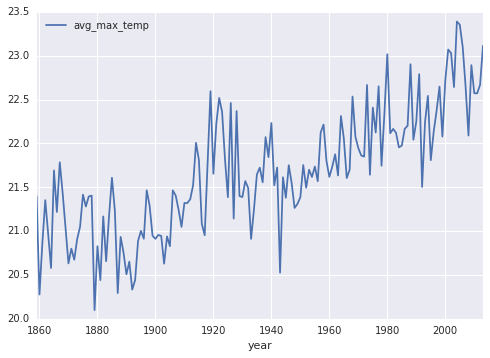

In [18]:
# visualise the results

import pandas as pd
from matplotlib import pyplot as plt

averageYearlyTempsPD = pd.DataFrame.from_records(averageYearlyTemps, columns=['year', 'avg_max_temp'], index='year')
plt.close()
averageYearlyTempsPD.plot()
plt.show()
display()

*How you interpret the chart above is up to you ;)*

You can now play around modifying pieces of the code.

When you are done and you are running off the local machine remember to *close the notebook* with `File/Close and Halt`.